# Import libraries

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import seaborn as sns
from copy import deepcopy
import sklearn.feature_selection
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from cleanlab.classification import CleanLearning

# Phase 1: EDA

In [138]:
#1-1
df=pd.read_csv('diabetes.csv')
print(df.describe())

       Pregnancies      Glucose  BloodPressure  SkinThickness     Insulin  \
count   635.000000   654.000000     680.000000     624.000000  680.000000   
mean      3.700787   113.422018      68.786765      20.386218   80.123529   
std       3.518126   202.816831      19.724841      15.987049  115.681140   
min     -22.000000 -5000.000000      -2.000000       0.000000    0.000000   
25%       1.000000    99.000000      62.000000       0.000000    0.000000   
50%       3.000000   117.000000      72.000000      23.000000   34.000000   
75%       6.000000   140.750000      80.000000      32.000000  129.250000   
max      17.000000   199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  684.000000                590.000000  655.000000  768.000000  
mean    32.083626                  0.466676   33.157252    0.348958  
std      7.800741                  0.322408   13.829831    0.476951  
min      0.000000         

In [139]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               635 non-null    float64
 1   Glucose                   654 non-null    float64
 2   BloodPressure             680 non-null    float64
 3   SkinThickness             624 non-null    float64
 4   Insulin                   680 non-null    float64
 5   BMI                       684 non-null    float64
 6   DiabetesPedigreeFunction  590 non-null    float64
 7   Age                       655 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB
None


In [140]:
#1-2
print(f'Number of lost data for each feature:\n {df.isnull().sum(axis = 0)}')

Number of lost data for each feature:
 Pregnancies                 133
Glucose                     114
BloodPressure                88
SkinThickness               144
Insulin                      88
BMI                          84
DiabetesPedigreeFunction    178
Age                         113
Outcome                       0
dtype: int64


In [141]:
print(f'Lost data percent for each feature :\n {df.isnull().sum()*100/len(df)}')

Lost data percent for each feature :
 Pregnancies                 17.317708
Glucose                     14.843750
BloodPressure               11.458333
SkinThickness               18.750000
Insulin                     11.458333
BMI                         10.937500
DiabetesPedigreeFunction    23.177083
Age                         14.713542
Outcome                      0.000000
dtype: float64


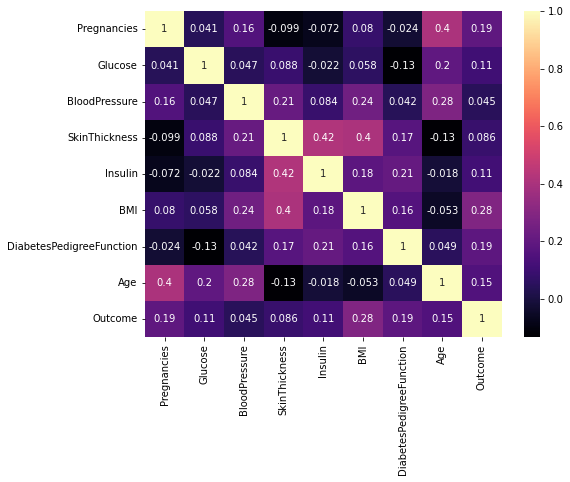

In [143]:
#1-3
sns.heatmap(df.corr(), cmap='magma', annot=True)
plot.rcParams['figure.figsize']=(8, 6)

<div dir = "rtl" style  = "font-size: 16px; font-family: Calibry;">
با توجه به نمودار میزان وابستگی ویژگی ها به یکدیگر که در بالا رسم شده است، ترتیب میزان وابستگی ویژگی ها به نتیحه به شکل زیر است :
    <br>
    <br>
BMI > Pregnancies = DiabetesPedigreeFunction > Age > Insulin = Glucose > SkinThickness > BloodPressure
</div>

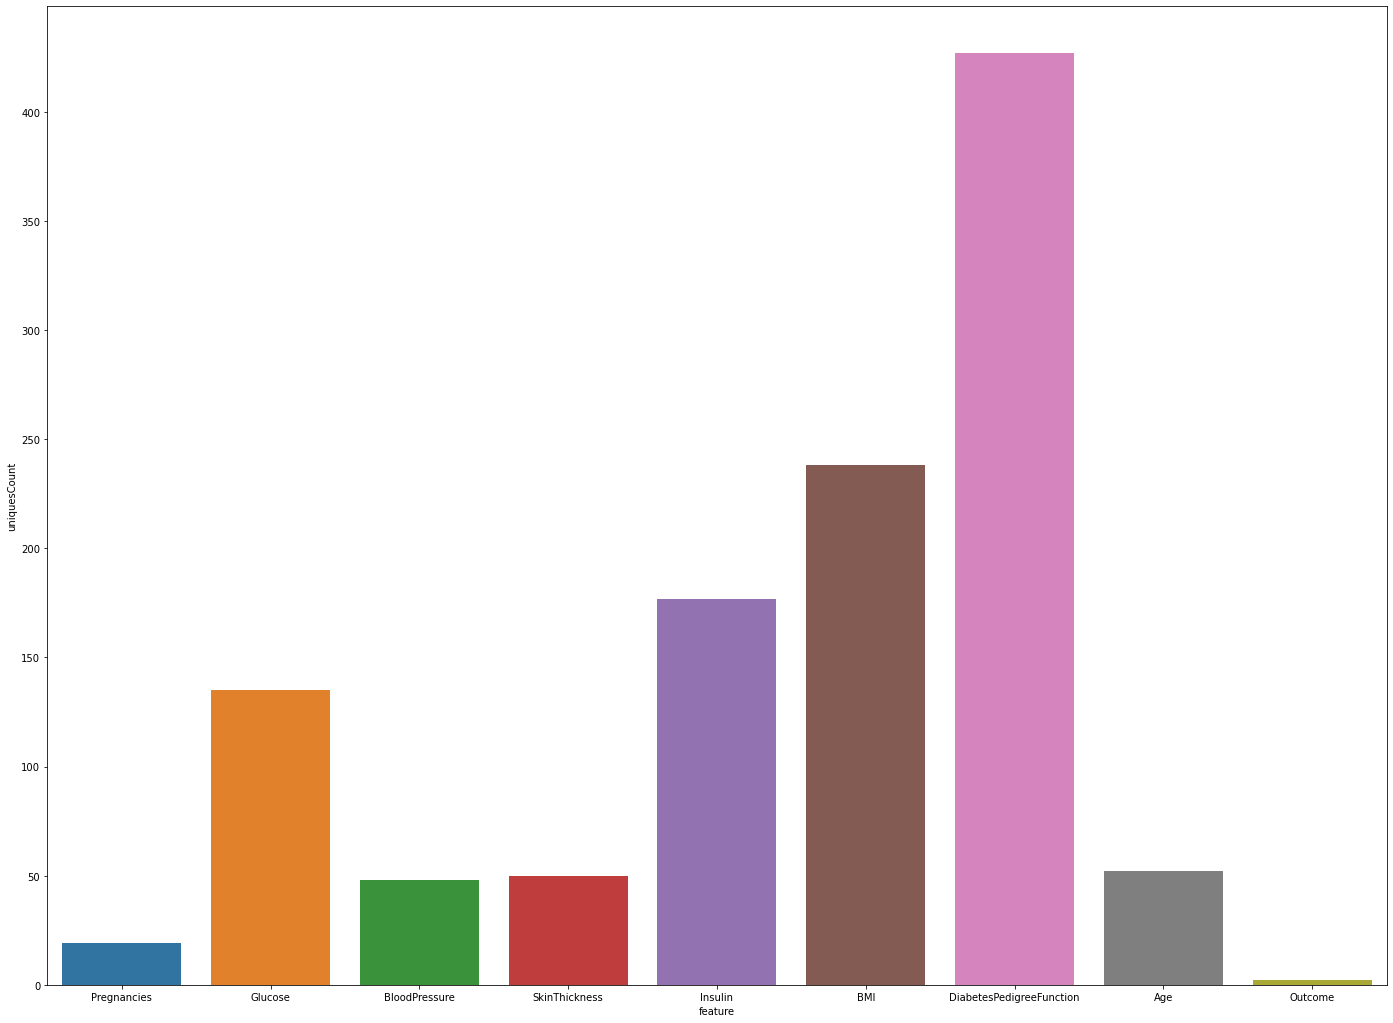

In [145]:
#1-4
uniquesDf=df.nunique().reset_index()
uniquesDf.columns=['feature', 'uniquesCount']
sns.barplot(x='feature', y='uniquesCount', data=uniquesDf)
plot.rcParams['figure.figsize']=(24, 18)

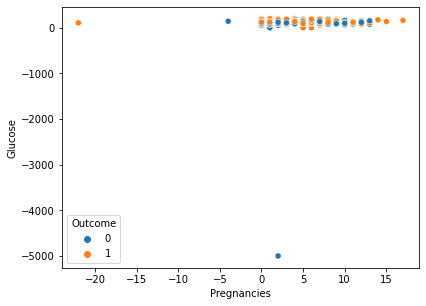

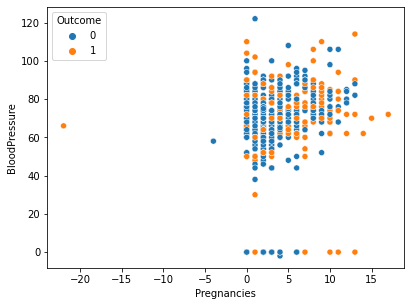

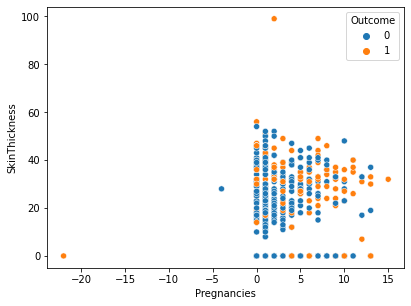

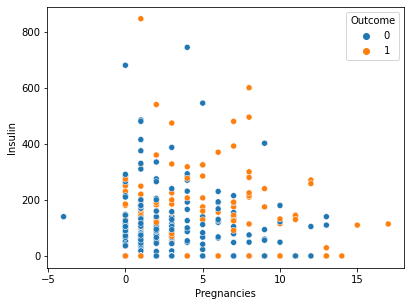

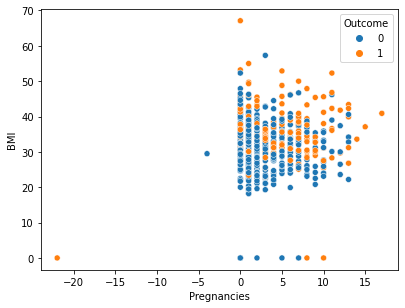

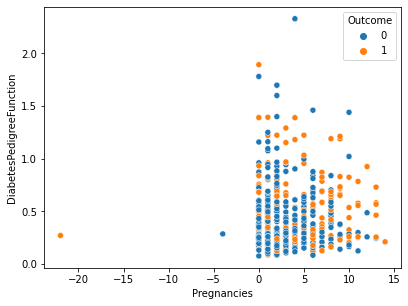

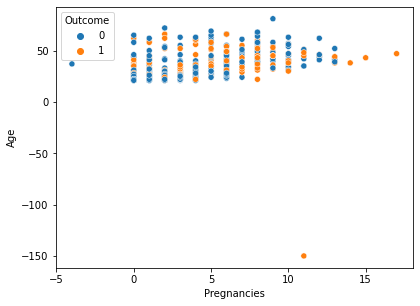

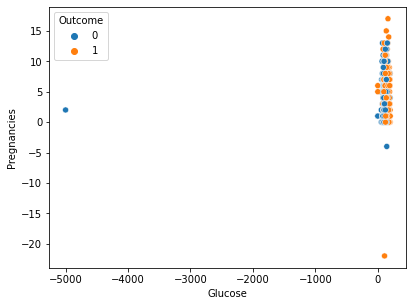

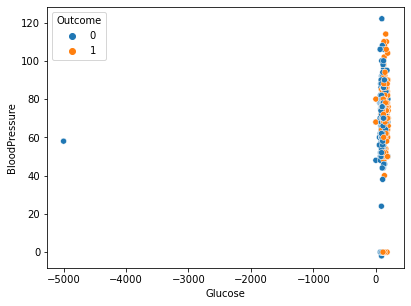

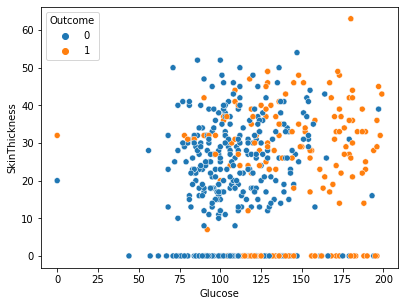

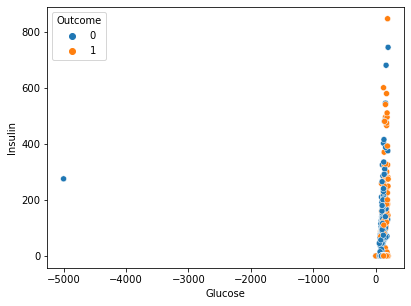

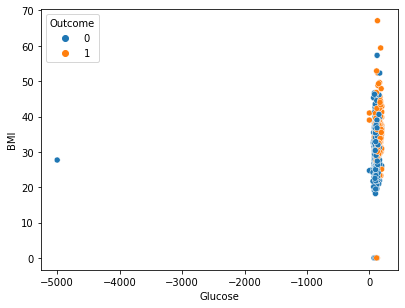

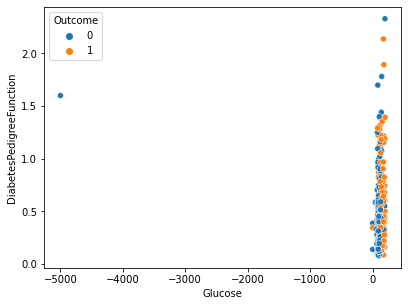

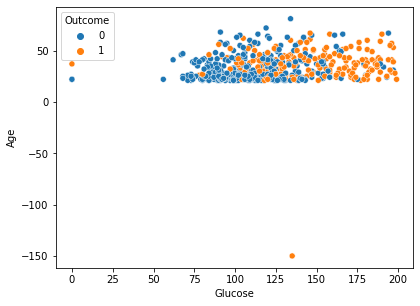

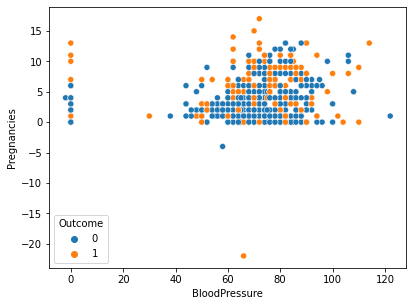

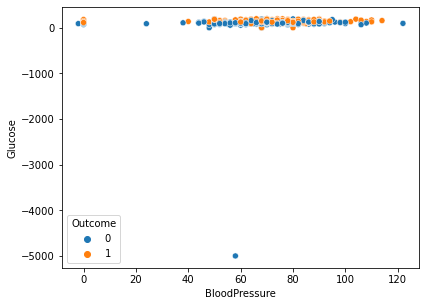

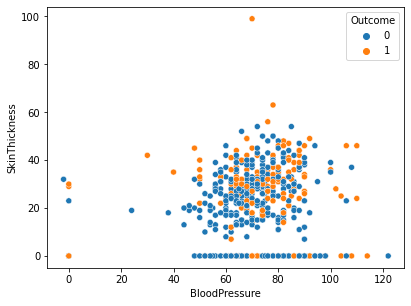

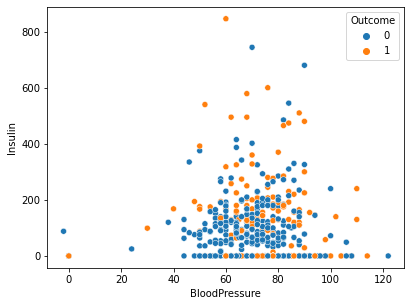

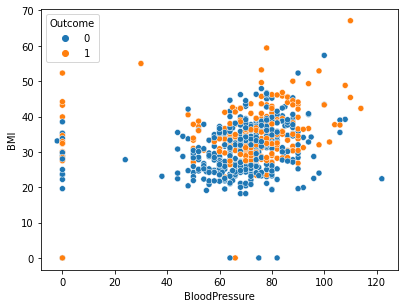

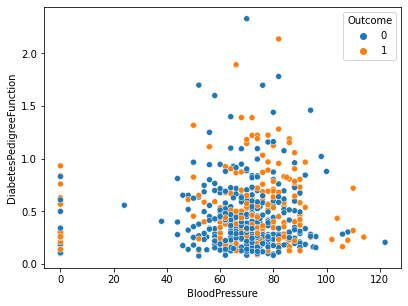

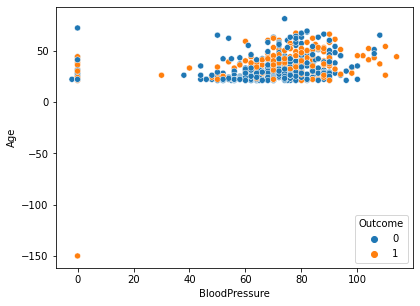

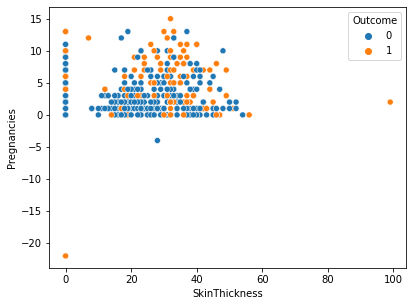

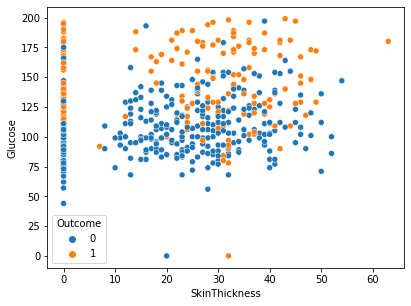

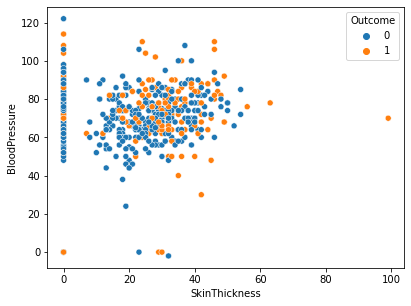

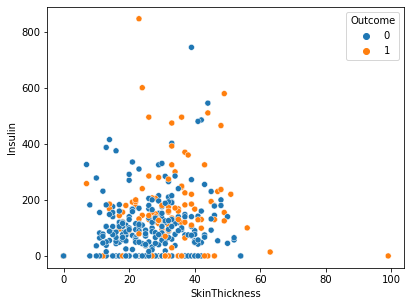

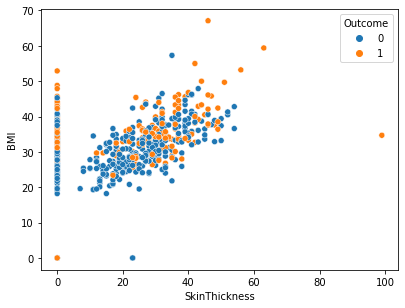

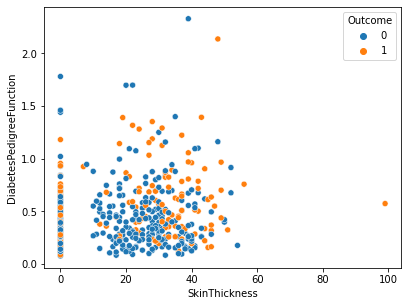

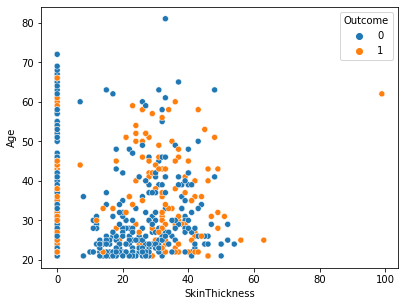

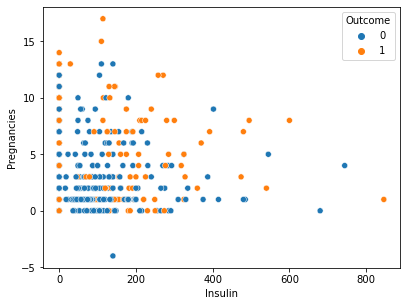

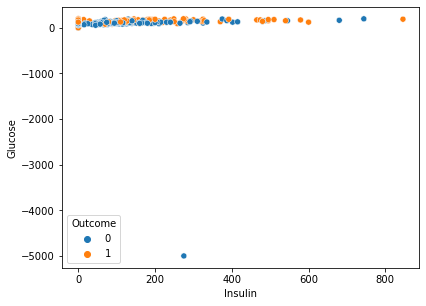

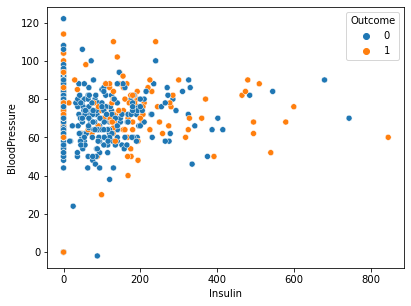

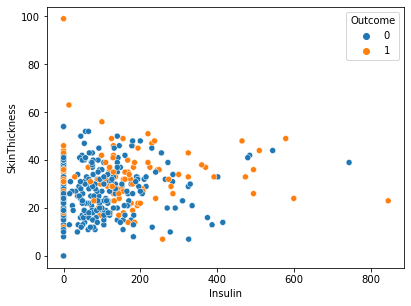

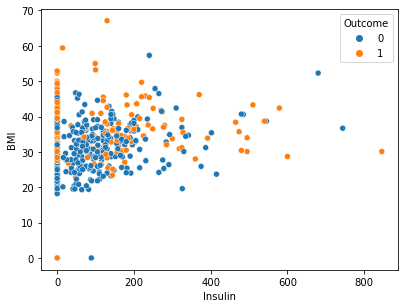

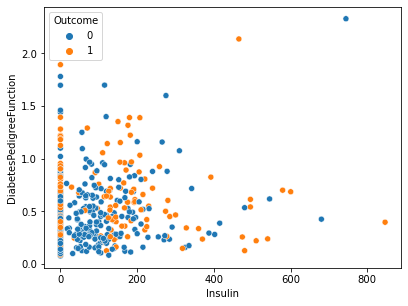

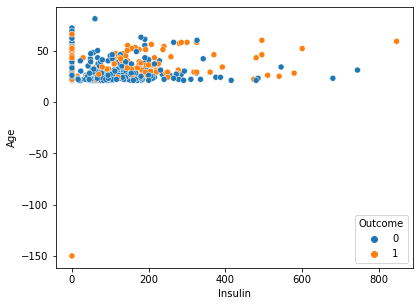

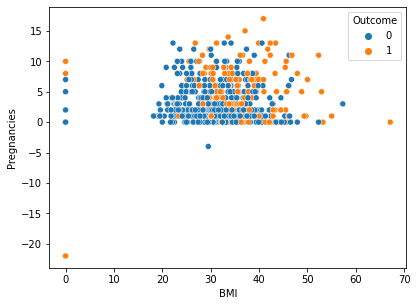

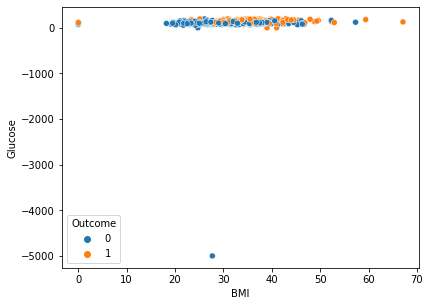

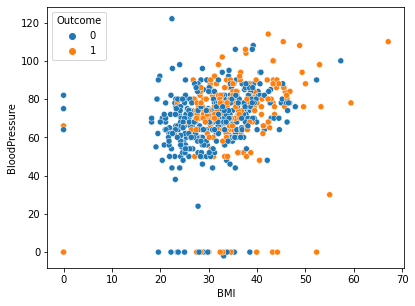

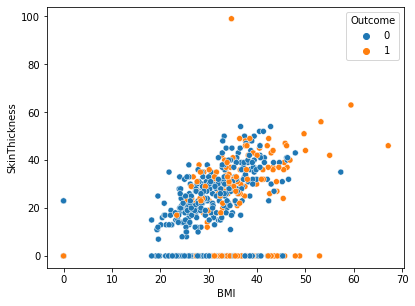

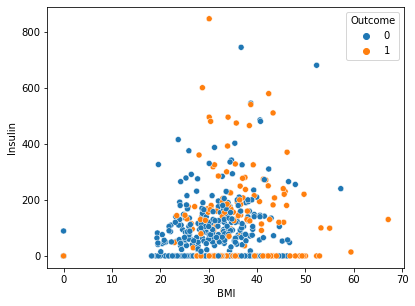

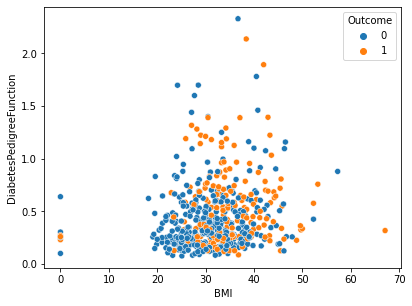

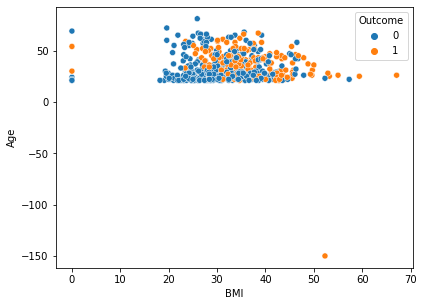

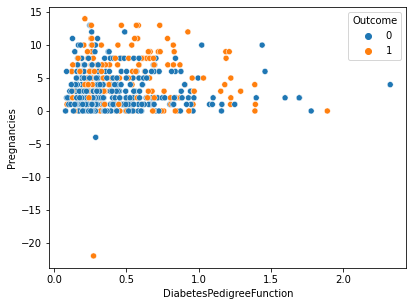

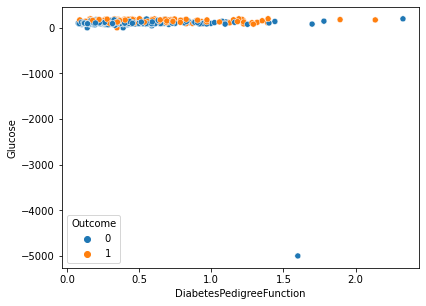

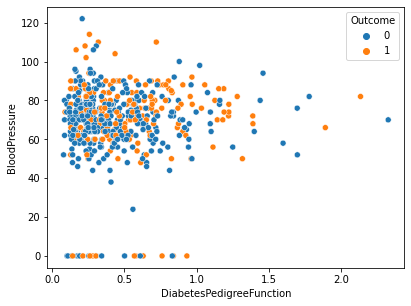

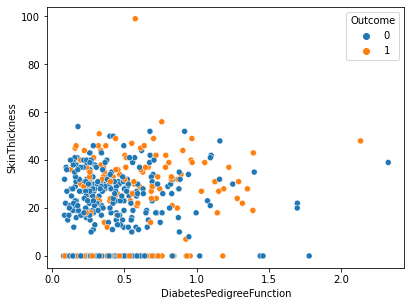

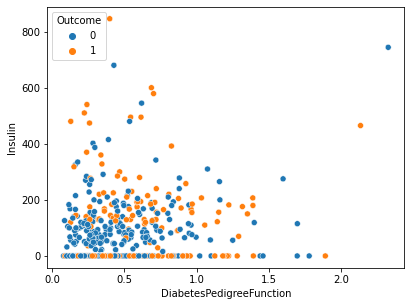

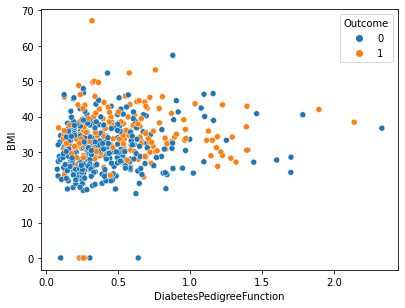

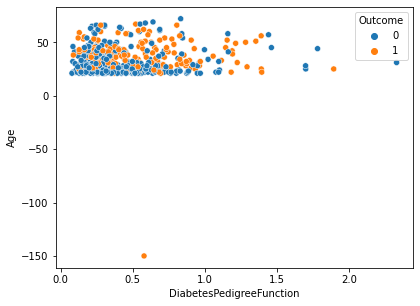

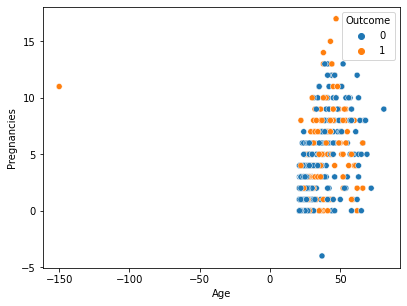

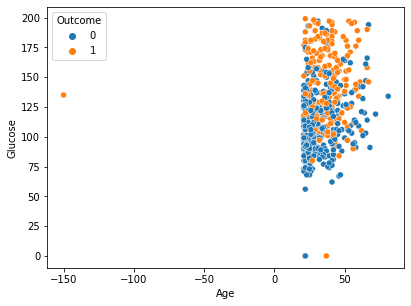

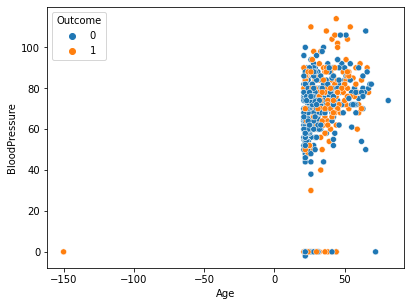

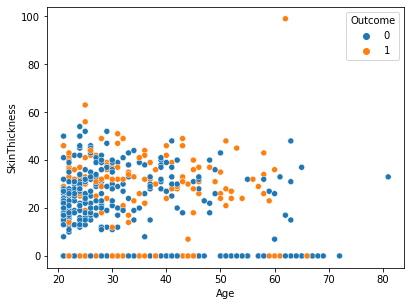

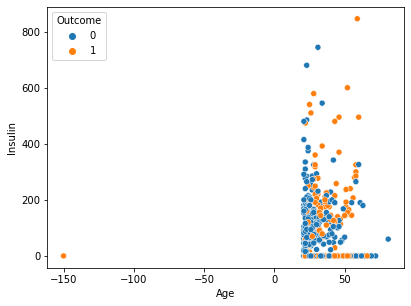

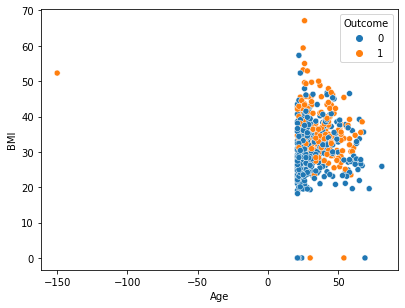

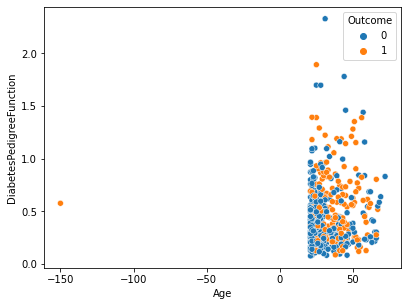

In [147]:
#1-5
for colName1 in df.columns:
    for colName2 in df.columns:
        if (colName1 != colName2) and (colName1 != 'Outcome') and (colName2 != 'Outcome'):
            sns.scatterplot(x=colName1, y=colName2, data=df, hue='Outcome')
            plot.rcParams['figure.figsize']=(6.4, 4.8)
            plot.show()

# Phase 2: Preprocessing

<div dir = "rtl" style  = "font-size: 16px; font-family: Calibri;">
    1−
    <br>
    <br>
    برای رفع مشکل داده های از دست رفته می توانیم :
    <br>
    <br>
    − داده هایی که مقدار NaN دارند را حذف کنیم. 
    <br>
    <br>
    ایراد این کار این است که احتمال دارد داده هایی که حذف کردیم اطلاعات مهمی داشته باشند یا داده های زیادی حذف شوند.
    <br>
    <br>
    مزیت این کار این است که آسان و سریع است.
    <br>
    <br>
    <br>
    − داده هایی که NaN هستند را با داده های آماری مانند میانگین، مود یا میانه پر کنیم.
    <br>
    <br>
    ایراد این روش این است که اگر یک ویژگی مقادیر NaN زیادی داشته باشد، یک داده بی معنی تولید خواهد شد.
    <br>
    <br>
    مزیت این روش این است که هیچ داده ای را از دست نخواهیم داد.
    <br>
    <br>
</div>

<div dir = "rtl" style  = "font-size: 16px; font-family: Calibri;">
    2-
    <br>
    <br>
    از لحاظ تعداد داده از دست رفته، وبژگی های موجود به شکل زیر از بیشترین به کمترین رتبه بندی می‌شوند:
    <br>
    <br>
    DiabetesPedigreeFunction > SkinThickness > Pregnancies > Glucose > Age >  BloodPressure =  Insulin > BMI
    <br>
    <br>
    داده های از دست رفته را با میانگین جایگزین می‌کنیم:
</div>

In [148]:
#2-2
df.apply(lambda column : column.fillna(column.mean(), inplace=True))

Pregnancies                 None
Glucose                     None
BloodPressure               None
SkinThickness               None
Insulin                     None
BMI                         None
DiabetesPedigreeFunction    None
Age                         None
Outcome                     None
dtype: object

<div dir = "rtl" style = "font-size: 16px">
با توجه به بخش EDA و توجه کردن به مقادیر مینیمم و ماکسیمم داده‌ها می‌توان فهمید
<br>
<br>
داده‌ها noisy هستند. چرا که به عنوان مثال کمترین مقدار سن 150- است!
<br>
<br>
پس در ابتدا داده‌هایی که نباید صفر یا منفی باشند را حذف می‌کنیم:
</div>

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   411.000000  411.000000     411.000000     411.000000  411.000000   
mean      3.345154  120.804728      70.829272      27.329325  143.600744   
std       2.889585   29.187004      11.848809       9.904646  113.444813   
min       0.000000   56.000000      24.000000       7.000000   14.000000   
25%       1.000000  100.000000      64.000000      20.386218   80.123529   
50%       3.000000  113.422018      70.000000      26.000000  106.000000   
75%       4.000000  136.000000      78.000000      33.000000  179.000000   
max      17.000000  198.000000     110.000000      63.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  411.000000                411.000000  411.000000  411.000000  
mean    32.885878                  0.503273   31.535956    0.328467  
std      6.664029                  0.285624    9.845577    0.470228  
min     19.300000                  

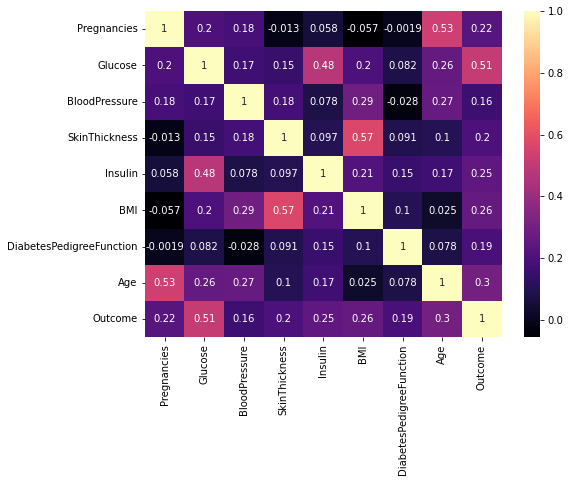

In [150]:
newDf=deepcopy(df)

biggerThanZerosCols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']

for col in biggerThanZerosCols :
    newDf.drop(newDf[(newDf[col] <= 0)].index, inplace=True)

newDf.drop(newDf[(newDf['Pregnancies'] < 0)].index, inplace=True)

print(newDf.describe())

sns.heatmap(newDf.corr(), cmap='magma', annot=True)
plot.rcParams['figure.figsize']=(8, 6)

<div dir = "rtl" style = "font-size: 16px">
    3-
    <br>
    <br>
    Normalization:
    <br>
    <br>
    از این روش زمانی استفاده می‌شود که داده ها توزیع نرمال نداشته باشند
    <br>
    <br>
    و هم چنین در مقیاس های متفاوتی باشند (دامنه تغییرات شان تفاوت زیادی با هم داشته باشد)
    <br>
    <br>
    این روش متغیر های عددی را به یک عدد بین ۰ و ۱ تبدیل می‌کند که معادله این تبدیل به شکل زیر است:
    <br>
    <br>
    $$ x_{new} = \frac{x_{old} - x_{min}}{x_{max} - x_{min}}$$
    <br>
    <br>
    <br>
    <br>
    Standardization:
    <br>
    <br>
    مشابه با normalization از این روش هم زمانی استفاده می‌شود که داده ها در مقیاس های متفاوتی
    <br>
    <br>
    باشند ولی از این روش معمولا زمانی استفاده می‌شود که توزیع اکثر داده ها نرمال باشد
    <br>
    <br>
    در این روش متغیر ها را به شکلی تغییر می‌دهیم که میانگین آن ها برار ۰ و انحراف معیارشان برابر ۱ باشد.
    <br>
    <br>
    $$x_{new} = \frac{x_{old} - \mu}{\sigma}$$
    <br>
    <br>
    در ادامه سعی می‌کنیم نوع توزیع داده ها را به دست آوریم تا تصمیم بگیریم از normalizing استفاده کنیم یا از standardizing.

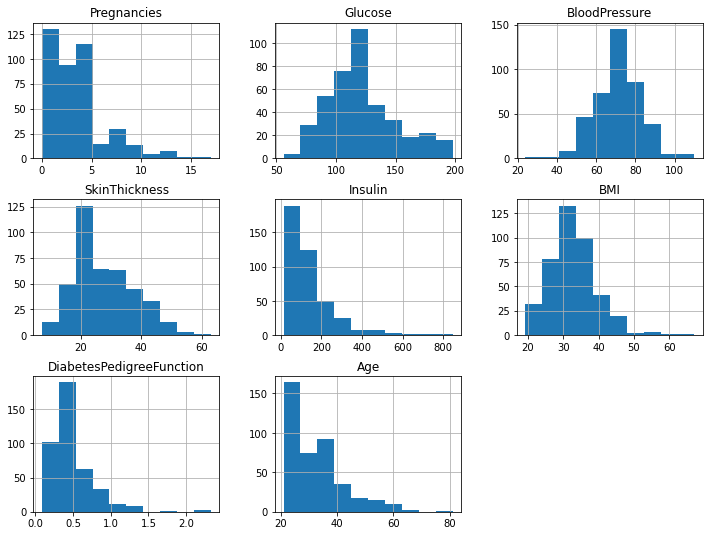

In [152]:
#2-3
x=newDf.drop('Outcome', axis=1)
y=newDf['Outcome']
x.hist()
plot.rcParams['figure.figsize']=(12, 9)
plot.show()

<div dir = "rtl" style = "font-size: 16px">
با توجه به نمودار های توزیع داده ها و این که بیشتر داده ها توزیع نرمال گاوسی ندارند
<br>
<br>
 و در range های متفاوتی هستند از normalization استفاده می‌کنیم.
</div>

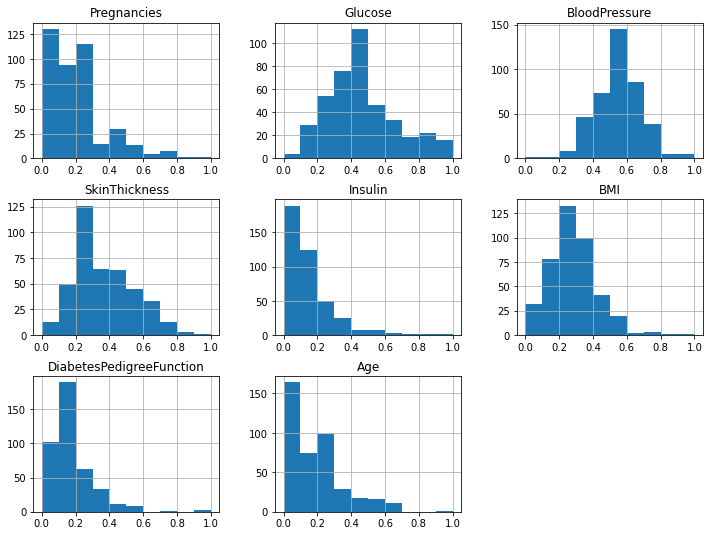

In [153]:
x=x.apply(lambda column : (column-column.min()) / (column.max()-column.min()))
x.hist()
plot.rcParams['figure.figsize']=(12, 9)
plot.show()

<div dir = "rtl" style = "font-size: 16px">
    4-
    <br>
    <br>
    برای پیش پردازش ویژگی های دسته‌ای روش های زیادی وجود دارد 
    <br>
    <br>
    که در اینجا به توضیح  ۶ مورد آن ها می‌پردازیم  :
    <br>
    <br>
    1-Create Dummies
    <br>
    <br>
    برای هر دسته موجود در آن ویژگی یک ستون باینری می‌سازیم. مقدار یک سطر از ستون باینری ۱ است
    <br>
    <br>
    اگر آن دسته در آن سطر وجود داشته باشد و در غیر این صورت صفر است.
    <br>
    <br>
    2-Ordinal Number Encoding
    <br>
    <br>
    زمانی که ویژگی دسته ای، از نوع ترتیبی باشد (یعنی ترتیب یا مرحله داشته باشد
    <br>
    <br>
    مانند مراحل تحصیل یا رتبه بندی و ...) ساده ترین روش این است که هر برچسب یا دسته
    <br>
    <br>
    را به ترتیب با یک عدد جایگزین کنیم. به عنوان مثال در مراحل تخصیل ابتدایی، راهنمایی و
    <br>
    <br>
    دبیرستان را با ۱، ۲ و ۳ جایگزین کنیم.
    <br>
    <br>
    3-Count / Frequency Encoding
    <br>
    <br>
    هر دسته را با تعداد دفعات تکرارش، جایگزین می‌کنیم.
    <br>
    <br>
    4-Target/Guided Encoding
    <br>
    <br>
    در این روش هر دسته از ستون با رتبه بندی احتمال توأم آن نسبت به ستون هدف
    <br>
    <br>
    جایگزین می‌شود.
    <br>
    <br>
    5-Mean Encoding
    <br>
    <br>
    کاملا مشابه با حالت قبلی است. فقط در اینجا به جای احتمال توأم نسبت به ستون
    <br>
    <br>
    از میانگین  نسبت به ستون هدف استفاده می‌کنیم.
    <br>
    <br>
    6-Probability Ratio Encoding
    <br>
    <br>
    در این روش هر دسته از ستون با نسبت احتمالش نسبت به متغیر هدف جایگزین می‌شود.
    <br>
    <br>
    با توجه به این که الگوریتم های machine learning با اعداد کار می‌کنند پس اگر داده دسته‌ای داشته باشیم
    <br>
    <br>
    که در تحلیل نتایج‌مان از اطلاعاتش استفاده می‌کنیم حتما باید عددی اش کنیم و از این روش‌ها بهره ببریم
    <br>
    <br>
    ولی اگر داده دسته‌ای داشته باشیم که اطلاعات پرتی داشته باشد و به دردمان نخورد می‌توانیم
    <br>
    <br>
    کاری به کارش نداشته باشیم یا حذفش کنیم و برای چنین داده ای نیازی به استفاده از این روش ها نیست.
    <br>
    <br>
    منبع : https://towardsdatascience.com/ways-to-handle-categorical-data-before-train-ml-models-with-implementation-ffc213dc84ec
    <br>
    <br>
</div>

<div dir = "rtl" style  = "font-size: 16px; font-family: Calibri;">
    5-
    <br>
    <br>
    ستون هایی برای حذف شدن مناسبند که مقادیر خالی زیادی داشته باشند، یا مقادیر یکتای زیادی داشته باشند
    <br>
    <br>
     و یا تأثیر کمی بر خروجی داشته باشند
    <br>
    <br>
    بنابراین با توجه به بخش های ۱−۲، ۱−۳ و ۱−۴ ویژگی های Age, SkinThickness و Insulin گزینه های مناسبی
    <br>
    <br>
    برای حذف کردن هستند.
    <br>
    <br>
    علت انتخاب Age: هم مشابهت زیادی با Pregnancies دارد و هم تأثیر کمی روی خروجی.
    <br>
    <br>
    علت انتخاب Skinthickness: هم تاثیر کمی روی خروجی دارد و هم مشابهت زیادی با Insulin و BMI دارد
    <br>
    <br>
    علت انتخاب Insulin: داده از دست رفته نسبتا زیادی دارد و شباهت خوبی با Glucose دارد.
    <br>
    <br>
    از مزایای حذف کردن ستون ها این است که مدل را ساده تر و سریع تر می‌کند. همچنین حذف نکردن ستون‌ها ممکن است
    <br>
    <br>
    باعث overfitting شود.
    <br>
    <br>
    از مشکلات حذف این ستون ها این است که ممکن است ستون های نامبرده به خودی خود، فایده ای نداشته باشند
    <br>
    <br>
    ولی شاید ترکیب آن ها اطلاعات سودمندی در اختیارمان قرار دهد که در صورت حذف شان این اطلاعات را
    <br>
    <br>
    از دست خواهیم داد.
    <br>
    <br>
    با توجه به آنچه گفته شد برای آنکه هم مدل مان کمی سریع تر شود و هم اطلاعات زیادی را از دست ندهیم،
    <br>
    <br>
    فقط ستون Insulin را حذف می‌کنیم.
</div>

In [154]:
#2-5
del x['Insulin']


<div dir = "rtl" style = "font-size: 16px">
6-
<br>
<br>
داده‌ها را به شکل تصادفی تقسیم می‌کنیم. در غیر این صورت ممکن است بخش زیادی از مجموعه test یا مجموعه train
<br>
<br>
شامل یک ویژگی خاص شود که در این صورت نمی‌توانیم ارزیابی درستی داشته باشیم و مدل مان بایاس دار می‌شود.
<br>
<br>
تقسیم تصادفی داده‌ها به مجموعه train و test توسط تابع train_test_split انجام می‌شود. به طوری که هر بار
<br>
<br>
این تابع را اجرا کنیم نتیجه متفاوتی به ما خواهد داد و اگر بخواهیم نتیجه‌ای که به ما می‌دهد همواره یکسان
<br>
<br>
باشد، کافی است به متغیر random_state یک عدد ثابت دلخواه بدهیم. در حالت عادی این متغیر، در هر بار
<br>
<br>
فراخوانی تابع یک مقدار تصادفی می‌گیرد به همین علت است که هر بار تابع را اجرا کنیم، نتیجه متفاوتی می‌گیریم.
<br>
<br>
متغیر test_size همانطور که از اسمش پیداست اندازه مجموعه test را مشخص می‌کند و مقداری که به آن می‌دهند
<br>
<br>
معمولا بین 0 تا 0.1 است
</div>

In [155]:
#2-6
xTrain, xTest, yTrain, yTest=train_test_split(x, y, test_size=0.1) 

<div dir = "rtl" style = "font-size: 16px">
7-
<br>
<br> 
از validation set برای ارزیابی مدل های unbiased در طی انتخاب hyperparameter های بهینه
<br>
<br>
برای یک الگوریتم یادگیری استفاده می‌شود.
<br>
<br>
به عنوان مثال وقتی می ‌خواهیم تعداد نورون‌های بهینه را در یک شبکه عصبی پیدا کنیم
<br>
<br>
با hyperparameter های مختلفی آزمایش خواهیم کرد. حال به ازای هر مجموعه از hyperparameter ها
<br>
<br>
مدلی که داریم را با training set تطابق می‌دهیم. (fit می‌کنیم)
<br>
<br>
و عملکرد (performance) آن را با به وسیله validation set می‌سنجیم.
</div>

# Phase 3: Model Training, Evaluation and Hyper Parameter Tuning

In [156]:
def show_result(model) :
    yPredTest=model.predict(xTest)
    yPredTrain=model.predict(xTrain)
    print(f'train accuracy : {accuracy_score(yTrain, yPredTrain)}')
    print(f'test accuracy : {accuracy_score(yTest, yPredTest)}')
    cm=confusion_matrix(yTest, yPredTest)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    print(classification_report(yTest, yPredTest))

# Decision Tree

Best depth = 5
train accuracy : 0.8292682926829268
test accuracy : 0.7857142857142857
              precision    recall  f1-score   support

           0       0.85      0.82      0.84        28
           1       0.67      0.71      0.69        14

    accuracy                           0.79        42
   macro avg       0.76      0.77      0.76        42
weighted avg       0.79      0.79      0.79        42



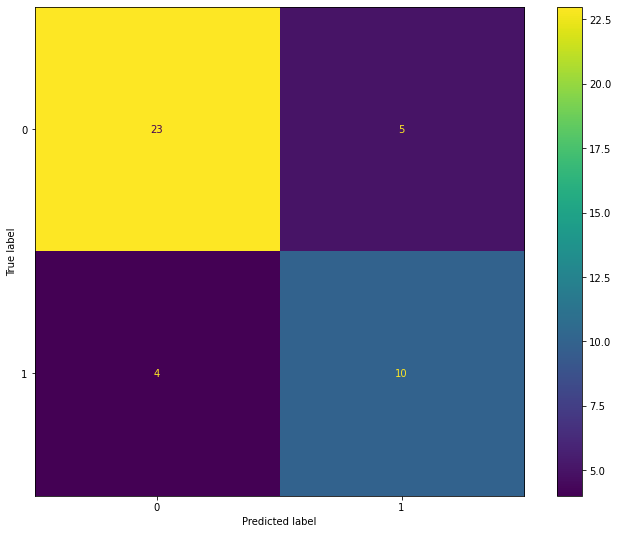

In [157]:
bestDepth, best=1, 0
for i in range(1, 50):
    treeClf=tree.DecisionTreeClassifier(max_depth=i)
    treeClf.fit(xTrain, yTrain)
    tmp = accuracy_score(yTest, treeClf.predict(xTest))
    if best < tmp :
        bestDepth, best = i, tmp
bestTree=CleanLearning(clf=tree.DecisionTreeClassifier(max_depth=bestDepth))
bestTree.fit(xTrain, yTrain)
print(f'Best depth = {bestDepth}')
show_result(bestTree)

# K-Nearest-Neighbours

Best number of neighbors = 3
train accuracy : 0.8157181571815718
test accuracy : 0.7380952380952381
              precision    recall  f1-score   support

           0       0.74      0.93      0.83        28
           1       0.71      0.36      0.48        14

    accuracy                           0.74        42
   macro avg       0.73      0.64      0.65        42
weighted avg       0.73      0.74      0.71        42



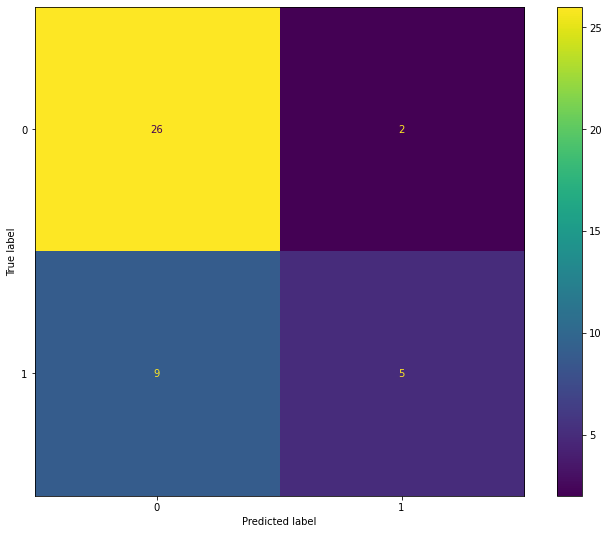

In [158]:
bestNeighbour, best=1, 0
for i in range(1, 50):
    knnClf=KNeighborsClassifier(n_neighbors=i)
    knnClf.fit(xTrain, yTrain)
    tmp = accuracy_score(yTest, knnClf.predict(xTest))
    if best < tmp :
        bestNeighbour, best = i, tmp
bestKnn=CleanLearning(clf=KNeighborsClassifier(n_neighbors=bestNeighbour))
bestKnn.fit(xTrain, yTrain)
print(f'Best number of neighbors = {bestNeighbour}')
show_result(bestKnn)

In [159]:
LRClf=LogisticRegression()
LRClf.fit(xTrain, yTrain)
solvers=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty=['l1', 'l2', 'elasticnet']
cValues=[0.01, 0.1, 1, 10, 100]
parameterTrials=dict(solver=solvers, penalty=penalty, C=cValues)
clf=GridSearchCV(LRClf, param_grid=parameterTrials, scoring='accuracy', cv=10, n_jobs=-1)
tmpclf=CleanLearning(clf)
bestLR=tmpclf.fit(xTrain, yTrain)
lr=clf.fit(xTrain, yTrain)


/home/javad/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
400 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/home/javad/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/javad/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/javad/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 61, in _check_solver
    r

{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
train accuracy : 0.7886178861788617
test accuracy : 0.8571428571428571
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        28
           1       0.90      0.64      0.75        14

    accuracy                           0.86        42
   macro avg       0.87      0.80      0.82        42
weighted avg       0.86      0.86      0.85        42



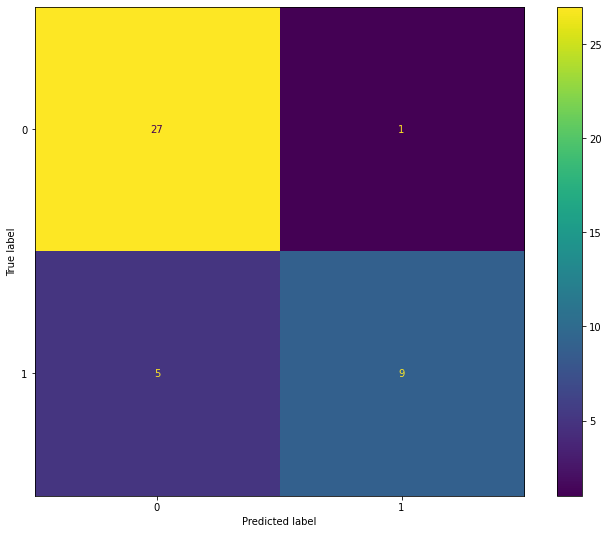

In [160]:
print(lr.best_params_)
show_result(bestLR)

<div dir = "rtl" style = "font-size: 16px">
3-
<br>
<br> 
underfitting: زمانی رخ می‌دهد که به دلایل گوناگون مانند کوچک بودن داده train، انتخاب بد فرا پارامتر ها و ...
<br>
<br>
نتوانیم مدل خود را به خوبی آموزش دهیم. در نتیحه دقت مدل کاهش می‌یابد و پیش بینی ها به خوبی انجام نخواهد شد.
<br>
<br>
overfitting: زمانی رخ می‌دهد که مدل مان آموزش خیلی دقیقی دیده باشد (بیش از اندازه آموزش دیده باشد)
<br>
<br>
که در این صورت ممکن است حتی noise ها هم مدل شوند و در نتیجه دقت مدل کاهش می‌یابد.
<br>
<br>
در مدل های ما این اتفاق‌ها رخ ندادند.
</div>

{'max_depth': 8, 'n_estimators': 450}
train accuracy : 0.959349593495935
test accuracy : 0.9047619047619048
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        28
           1       1.00      0.71      0.83        14

    accuracy                           0.90        42
   macro avg       0.94      0.86      0.88        42
weighted avg       0.92      0.90      0.90        42



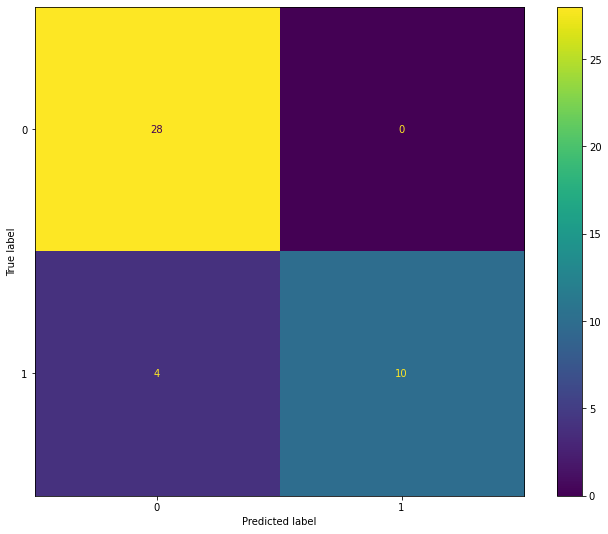

In [161]:
RFClf=RandomForestClassifier()
RFClf.fit(xTrain, yTrain)
parameterTrials={'n_estimators':[5, 10, 50, 100, 250, 300, 400, 450, 500, 600], 'max_depth':[i for i in range(1, 11)]}
clf=GridSearchCV(RFClf, param_grid=parameterTrials, scoring='accuracy', cv=10, n_jobs=-1)
tmpclf=CleanLearning(clf)
bestRF=tmpclf.fit(xTrain, yTrain)
rf=clf.fit(xTrain, yTrain)
print(rf.best_params_)
show_result(bestRF)

<div dir = "rtl" style = "font-size: 16px">
1-
<br>
<br> 
n_estimators: این متغیر برابر تعداد درخت های جنگل است و افزایش آن تا حدودی می‌تواند
<br>
<br>
باعث بهبود دقت شود ولی افزایش بیش از حد آن ممکن است باعث بدتر شدن دقت شود چرا که ممکن است
<br>
<br>
درخت‌ها به یکدیگر وابستگی پیدا کنند.
<br>
<br>
max_depth: این متغیر برابر حداکثر ارتفاع هر درخت است. افزایش این متغیر باعث می‌شود که مدل با
<br>
<br>
داده train بیشتر فیت شود. پس کاهش آن می‌تواند باعث کاهش واریانس و افزایش بایاس شود.
</div>

Best depth = 12


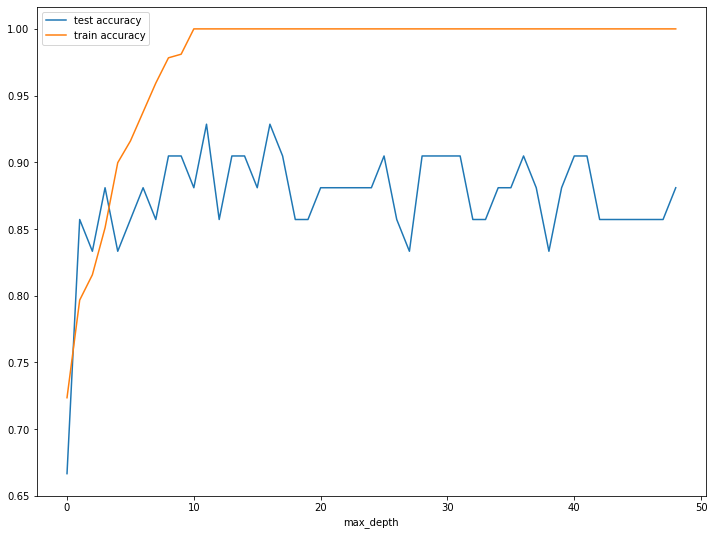

In [162]:
trainAcc, testAcc= [], []
bestDepth, best=1, 0
for i in range(1, 50):
    RFClf=RandomForestClassifier(max_depth=i)
    RFClf.fit(xTrain, yTrain)
    trainAcc.append(accuracy_score(yTrain, RFClf.predict(xTrain)))
    tmp = accuracy_score(yTest, RFClf.predict(xTest))
    testAcc.append(tmp)
    if best < tmp:
        bestDepth, best = i, tmp

print(f'Best depth = {bestDepth}')
plot.plot(testAcc)
plot.plot(trainAcc)
plot.xlabel('max_depth')
plot.legend(["test accuracy", "train accuracy"])

Best number of estimators = 171


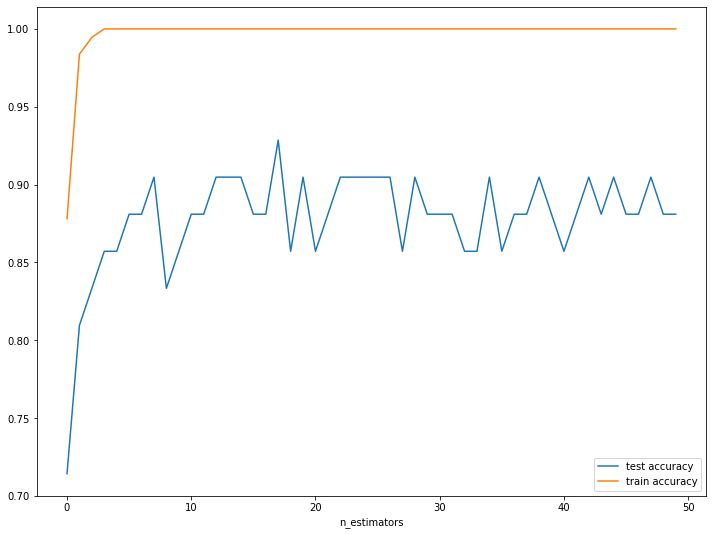

In [163]:
trainAcc, testAcc= [], []
bestEstimators, best=1, 0
for i in range(1, 500, 10):
    RFClf=RandomForestClassifier(n_estimators=i)
    RFClf.fit(xTrain, yTrain)
    trainAcc.append(accuracy_score(yTrain, RFClf.predict(xTrain)))
    tmp = accuracy_score(yTest, RFClf.predict(xTest))
    testAcc.append(tmp)
    if best < tmp:
        bestEstimators, best = i, tmp

print(f'Best number of estimators = {bestEstimators}')
plot.plot(testAcc)
plot.plot(trainAcc)
plot.xlabel('n_estimators')
plot.legend(["test accuracy", "train accuracy"])

train accuracy : 1.0
test accuracy : 0.9047619047619048
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        28
           1       1.00      0.71      0.83        14

    accuracy                           0.90        42
   macro avg       0.94      0.86      0.88        42
weighted avg       0.92      0.90      0.90        42



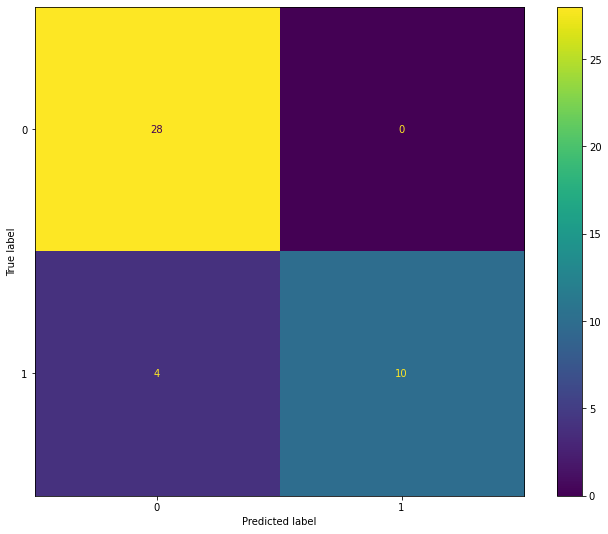

In [164]:
RFClf=RandomForestClassifier(n_estimators=bestEstimators, max_depth=bestDepth)
RFClf.fit(xTrain, yTrain)
show_result(RFClf)

<div dir = "rtl" style = "font-size: 16px">
2-
<br>
<br> 
bias: مقدار تفاوت پیش بینی مدل با مقدار واقعی در قیاس با داده train است. که مقدار زیاد آن می‌تواند موجب underfitting شود.
<br>
<br>
variance: میزان تفاوت یک متغیر تصادفی با مقدار مورد انتظار آن است. در واقع واریانس نشان می‌دهد که در صورت استفاده از داده های
<br>
<br>
train متفاوت، تخمینی که از مقدار واقعی می‌زنیم چه مقدار تغییر می‌کند.
<br>
<br>
variance و biase با یکدیگر رابطه معکوس دارند، یعنی هر چه واریانس افزایش یابد، بایاس  کاهش  می‌یابد و برعکس.
<br>
<br>
از نظر بایاس، decision tree و از نظر واریانس random forest عملکرد بهتری دارد.
<br>
<br>
نتایح به دست آمده نیز با آن چه گفته شد، مطابقت داشت.
</div>